# Лабораторная работа 4.1.1

#### Исследование центрированных оптических систем

### Библиотеки 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        print("a = {:.0{prec}f} sig_a = {:.0{prec}f}".format(popt[0], errors[0], prec = precA))
        print("b = {:.0{prec}f} sig_b = {:.0{prec}f}".format(popt[1], errors[1], prec = precB), '\n')

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [3]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

### Определение фокусных расстояний тонких линз методом Аббе

In [4]:
# f  - расстояние от линзы до изображения, см.
# d  - расстояние от линзы до предмета, см.
# fd - расстояние от изображения до предмета, fd = f + d, см.
# a  - размер предмета, см.
# b  - размер изображения, см.

abbe = {
    "a" : 2,
    "sig_r" : 0.05,
    "samples" : [
        { # 1
            "f"  : 17.8,
            "fd" : 41.4 + 1.3,
            "b"  : 1.5,
        },
        { # 2
            "f"  : 28.1,
            "fd" : 43.2 + 1.3,
            "b"  : 3.6,
        },
        { # 3
            "f"  : 22,
            "fd" : 40.2 + 1.3,
            "b"  : 2.4,
        },
        { # 4
            "f"  : 37.1,
            "fd" : 50.3 + 1.3,
            "b"  : 5.2,
        },
        { # 5
            "f"  : 58.1,
            "fd" : 69.5 + 1.3,
            "b"  : 9.3,
        },
        { # 6
            "f"  : 50.4,
            "fd" : 62.2 + 1.3,
            "b"  : 7.8,
        },
    ],
    "points" : [],
    "f" : [],
    "f'": [],
    "sig_f" :[],
    "sig_f'":[],
    "n"     : np.array(range(1, 6)),
    "avg_f" : 0,
    "avg_f'": 0,
    "sig_avg_f" : 0,
    "sig_avg_f'": 0,
    "eps_avg_f" : 0,
    "eps_avg_f'": 0
}

for sample in abbe["samples"]:
    sample["d"] = sample["fd"] - sample["f"]

for st in range(1, len(abbe["samples"])):
    prev = abbe["samples"][st - 1]
    curr = abbe["samples"][st]
    point = dict()
    point["dx'"]   = abs(curr["f"] - prev["f"])
    point["dx"]    = abs(curr["d"] - prev["d"])
    point["dy/y'"] = abs(abbe["a"]/curr["b"] - abbe["a"]/prev["b"])
    point["dy'/y"] = abs(curr["b"]/abbe["a"] - prev["b"]/abbe["a"])
    point["f"]     = point["dx"] / point["dy/y'"]
    point["f'"]    = point["dx'"] / point["dy'/y"]

    point["sig_dx'"] = (2)**0.5 * abbe["sig_r"]
    point["sig_dx"]  = (2)**0.5 * abbe["sig_r"]
    point["sig_dy/y'"] = ((abbe["sig_r"])**2/(curr["b"])**4 + (abbe["sig_r"])**2/(prev["b"])**4)**0.5 * abbe["a"]
    point["sig_dy'/y"] = (2)**0.5 * abbe["sig_r"] / abbe["a"]

    point["eps_dx'"] = point["sig_dx'"] / point["dx'"]
    point["eps_dx"]  = point["sig_dx"]  / point["dx"]
    point["eps_dy/y'"] = point["sig_dy/y'"] / point["dy/y'"]
    point["eps_dy'/y"] = point["sig_dy'/y"] / point["dy'/y"]

    point["eps_f"] = (point["eps_dx"]**2 + point["eps_dy/y'"]**2)**0.5
    point["sig_f"] = point["eps_f"] * point["f"]

    point["eps_f'"] = (point["eps_dx'"]**2 + point["eps_dy'/y"]**2)**0.5
    point["sig_f'"] = point["eps_f'"] * point["f'"]

    print("dx      = ", point["dx"],
        "\ndx'     = ", point["dx'"],
        "\ndy/y'   = ", point["dy/y'"],
        "\ndy'/y   = ", point["dy'/y"],
        "\nf       = ", point["f"], "\t+- ", point["sig_f"],
        "\nf'      = ", point["f'"], "\t+- ", point["sig_f'"],
        "\n\n")
    
    abbe["avg_f"] += point["f"]
    abbe["avg_f'"] += point["f'"]

    abbe["points"].append(point)
    abbe["f"].append(point["f"])
    abbe["f'"].append(point["f'"])
    abbe["sig_f"].append(point["sig_f"])
    abbe["sig_f'"].append(point["sig_f'"])

abbe["avg_f"] /= max(abbe["n"])
abbe["avg_f'"] /= max(abbe["n"])

for point in abbe["points"]:
    abbe["sig_avg_f"] += (point["f"] - abbe["avg_f"])**2
    abbe["sig_avg_f'"] += (point["f'"] - abbe["avg_f'"])**2

abbe["sig_avg_f"] = (1 / (max(abbe["n"]) * (max(abbe["n"]) - 1) ) * abbe["sig_avg_f"])**0.5
abbe["sig_avg_f'"] = (1 / (max(abbe["n"]) * (max(abbe["n"]) - 1) ) * abbe["sig_avg_f'"])**0.5

abbe["eps_avg_f"] = abbe["sig_avg_f"] / abbe["avg_f"]
abbe["eps_avg_f'"] = abbe["sig_avg_f'"] / abbe["avg_f'"]

abbe["f"] = np.array(abbe["f"])
abbe["f'"] = np.array(abbe["f'"])
abbe["sig_f"] = np.array(abbe["sig_f"])
abbe["sig_f'"] = np.array(abbe["sig_f'"])

abbe["dptr"] = 1 / 0.105
abbe["eps_dptr"] = abbe["eps_avg_f"]
abbe["sig_dptr"] = abbe["dptr"] * abbe["eps_dptr"]

dx      =  8.499999999999996 
dx'     =  10.3 
dy/y'   =  0.7777777777777777 
dy'/y   =  1.05 
f       =  10.928571428571425 	+-  0.6403181659978021 
f'      =  9.80952380952381 	+-  0.33709906456504557 


dx      =  3.1000000000000014 
dx'     =  6.100000000000001 
dy/y'   =  0.2777777777777778 
dy'/y   =  0.6000000000000001 
f       =  11.160000000000005 	+-  0.8046155914472456 
f'      =  10.166666666666668 	+-  0.6105584622314797 


dx      =  5.000000000000007 
dx'     =  15.100000000000001 
dy/y'   =  0.4487179487179488 
dy'/y   =  1.4000000000000001 
f       =  11.142857142857157 	+-  0.46811665737785846 
f'      =  10.785714285714286 	+-  0.27702366805273354 


dx      =  1.7999999999999972 
dx'     =  21.0 
dy/y'   =  0.1695616211745244 
dy'/y   =  2.0500000000000003 
f       =  10.615609756097545 	+-  0.4824445795179918 
f'      =  10.243902439024389 	+-  0.1800072187562418 


dx      =  0.4000000000000057 
dx'     =  7.700000000000003 
dy/y'   =  0.04135649296939625 
dy'/y  

In [5]:
print(abbe["avg_f"], "\t+-", abbe["sig_avg_f"])
print(abbe["dptr"], "\t+-", abbe["sig_dptr"])
print(abbe["avg_f'"],"\t+-", abbe["sig_avg_f'"])

10.703807665505252 	+- 0.2760254126544738
9.523809523809524 	+- 0.24559610336832816
10.254494773519164 	+- 0.1562317921906286


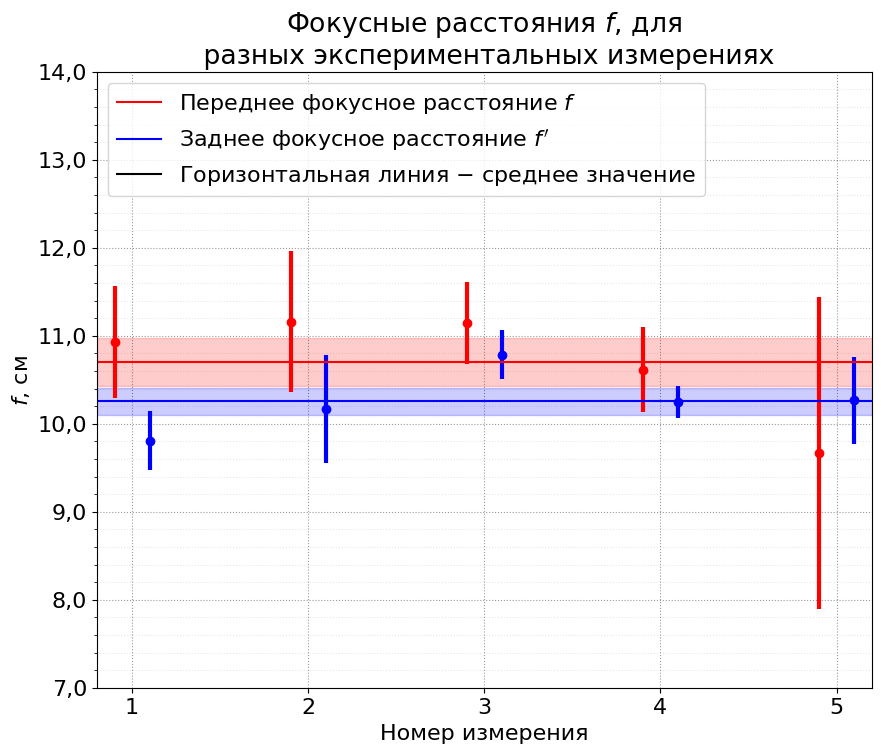

In [6]:
xMin = 0.8
xMax = 5.201

yMin = 7
yMax = 14.001

plotTitle       = 'Фокусные расстояния $f$, для\n разных экспериментальных измерениях'

xLabel          = r'Номер измерения'
yLabel          = r'$f$, см'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0.2
yMajorStep      = 1

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 1

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,8), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

x = np.array([xMin, xMax])

plt.errorbar(abbe["n"] - 0.1, abbe["f"], yerr = abbe["sig_f"], fmt = 'o', linewidth = 3, color = 'red')
plt.errorbar(abbe["n"] + 0.1, abbe["f'"], yerr = abbe["sig_f'"], fmt = 'o', linewidth = 3, color = 'blue')

plt.plot(x, np.array([abbe["avg_f"]]  * 2), color = 'red', label = "Переднее фокусное расстояние $f$")
plt.plot(x, np.array([abbe["avg_f'"]] * 2), color = 'blue', label = "Заднее фокусное расстояние $f'$")

rect_f1 = mpl.patches.Rectangle((xMin, abbe["avg_f"] - abbe["sig_avg_f"]),
                               xMax - xMin, 2 * abbe["sig_avg_f"],
                               color = 'red',
                               alpha = 0.2)
axes.add_patch(rect_f1)

rect_f2 = mpl.patches.Rectangle((xMin, abbe["avg_f'"] - abbe["sig_avg_f'"]),
                               xMax - xMin, 2 * abbe["sig_avg_f'"],
                               color = 'blue',
                               alpha = 0.2)
axes.add_patch(rect_f2)

plt.plot(0, 0, color = 'black', label = "Горизонтальная линия $-$ среднее значение")

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(1, 5.001, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/abbe_f.png")
plt.show()

### Определение фокусных расстояний методом Бесселя

In [22]:
# f  - расстояние от линзы до изображения, см.
# d  - расстояние от линзы до предмета, см.
# fd - расстояние от изображения до предмета, fd = f + d, см.
# a  - размер предмета, см.
# b  - размер изображения, см.

bessel = {
    "a" : 2,
    "sig_r" : 0.05,
    "samples" : [
        { # 1
            "f1" : 50.3,
            "f2" : 12.4,
            "L"  : 62.2 + 1.3,
        },
        { # 2
            "f1" : 89.5,
            "f2" : 11.1,
            "L"  : 100 + 1.3,
        },
        { # 3
            "f1" : 79.3,
            "f2" : 11.56,
            "L"  : 90 + 1.3,
        },
        { # 4
            "f1" : 69,
            "f2" : 11.7,
            "L"  : 79.9 + 1.3,
        },
        { # 5
            "f1" : 58.7,
            "f2" : 12,
            "L"  : 70.1 + 1.3,
        },
        { # 6
            "f1" : 36.5,
            "f2" : 14.6,
            "L"  : 49.8 + 1.3,
        },
        { # 7
            "f1" : 30.5,
            "f2" : 15.8,
            "L"  : 44.9 + 1.3,
        },
        { # 8
            "f1" : 21.3,
            "f2" : 19.8,
            "L"  : 39.6 + 1.3,
        }
    ],

    "n" : np.array(range(1, 9)),
    "f" : [],
    "sig_f" :[],
    "avg_f" : 0,
    "sig_avg_f" : 0,
    "eps_avg_f" : 0,
    "delta"     : 0.5 # см
}

bessel["sig_l"] = (2)**0.5 * bessel["sig_r"]

for sample in bessel["samples"]:
    sample["l"] = sample["f1"] - sample["f2"]

    sample["f"] = (sample["L"]**2 - sample["l"]**2) / (4 * sample["L"])
    sample["sig_f"] = ((sample["L"]**2 + sample["l"]**2)**2 / (16 * sample["L"]**4) * bessel["sig_r"]**2 + 
                       sample["l"]**2 / (4 * sample["L"]**2) * bessel["sig_l"])**0.5
    sample["eps"] = ( (sample["L"])**2 + (sample["l"])**2 ) / (
                      (sample["L"])**2 - (sample["l"])**2 ) * (
                    bessel["delta"]) / (sample["L"])
    
    sample["sig_f"] = (sample["sig_f"]**2 + (sample["eps"] * sample["f"])**2)**0.5

    bessel["avg_f"] += sample["f"]
    
    print("l = ", sample["l"],
        "\nf = ", sample["f"], "\t+-", sample["sig_f"],
        "\n\n")
    
    bessel["f"].append(sample["f"])
    bessel["sig_f"].append(sample["sig_f"])

bessel["avg_f"] /= max(bessel["n"])

for sample in bessel["samples"]:
    bessel["sig_avg_f"] += (sample["f"] - bessel["avg_f"])**2

bessel["sig_avg_f"] = (1 / (max(bessel["n"]) * (max(bessel["n"]) - 1) ) * bessel["sig_avg_f"])**0.5
bessel["eps_avg_f"] = bessel["sig_avg_f"] / bessel["avg_f"]

bessel["dptr"] = 1 / 0.1021
bessel["eps_dptr"] = bessel["eps_avg_f"]
bessel["sig_dptr"] = bessel["dptr"] * bessel["eps_dptr"]

bessel["f"] = np.array(bessel["f"])
bessel["sig_f"] = np.array(bessel["sig_f"])

l =  37.9 
f =  10.21984251968504 	+- 0.18794876163825805 


l =  78.4 
f =  10.15579960513326 	+- 0.2256926288952283 


l =  67.74 
f =  10.260083242059142 	+- 0.21833405112683993 


l =  57.3 
f =  10.191348522167491 	+- 0.21027190103334986 


l =  46.7 
f =  10.213830532212882 	+- 0.19933427486505717 


l =  21.9 
f =  10.428571428571427 	+- 0.15924119481734675 


l =  14.7 
f =  10.380681818181817 	+- 0.1446653308307365 


l =  1.5 
f =  10.211246943765282 	+- 0.1258868883369722 




In [23]:
print(bessel["avg_f"], "\t+-", bessel["sig_avg_f"])
print(bessel["dptr"], "\t+-", bessel["sig_dptr"])
print(bessel["n"])

10.257675576472042 	+- 0.033971906017486446
9.79431929480901 	+- 0.03243733846990542
[1 2 3 4 5 6 7 8]


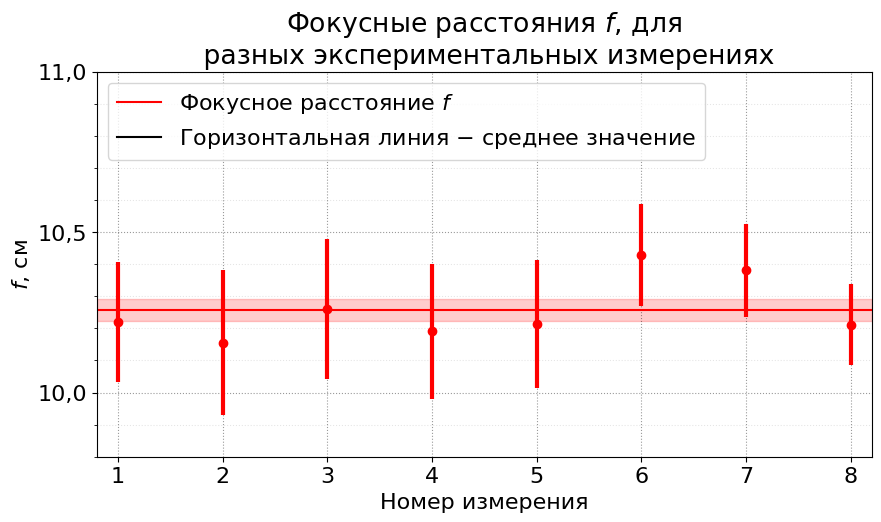

In [24]:
xMin = 0.8
xMax = 8.201 # max(bessel["n"])

yMin = 9.8
yMax = 11.0001

plotTitle       = 'Фокусные расстояния $f$, для\n разных экспериментальных измерениях'

xLabel          = r'Номер измерения'
yLabel          = r'$f$, см'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0.1
yMajorStep      = 0.5

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 1

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,5), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

x = np.array([xMin, xMax])

n = np.array(list(range(1, 9)))
plt.errorbar(n, bessel["f"], yerr = bessel["sig_f"], fmt = 'o', linewidth = 3, color = 'red')

plt.plot(x, np.array([bessel["avg_f"]]  * 2), color = 'red', label = "Фокусное расстояние $f$")

rect_f1 = mpl.patches.Rectangle((xMin, bessel["avg_f"] - bessel["sig_avg_f"]),
                               xMax - xMin, 2 * bessel["sig_avg_f"],
                               color = 'red',
                               alpha = 0.2)
axes.add_patch(rect_f1)

plt.plot(0, 0, color = 'black', label = "Горизонтальная линия $-$ среднее значение")

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(0, 20, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(1, 8.001, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/bessel_full_f.png")
plt.show()

### Определение фокусного расстояния рассеивающей линзы

In [29]:
# f  - расстояние от линзы до изображения, см.
# d  - расстояние от линзы до предмета, см.
# fd - расстояние от изображения до предмета, fd = f + d, см.
# a  - размер предмета, см.
# b  - размер изображения, см.

otr = {
    "a" : 2,
    "sig_r" : 0.05,
    "samples" : [
        { # 1
            "f1" : 20.5,
            "L1" : 40.3 + 1.3,
            "f2" : 37,
            "lf2": 47.7,
        },
        { # 2
            "f1" : 16.7,
            "L1" : 43.3 + 1.3,
            "f2" : 41.4,
            "lf2": 47.8,
        },
        { # 3
            "f1" : 28.1,
            "L1" : 43.3 + 1.3,
            "f2" : 16,
            "lf2": 37.2,
        },
        # { # 4
        #     "f1" : 49.3,
        #     "L1" : 61.2 + 1.3,
        #     "f2" : 23.6,
        #     "lf2": 62.7,
        # },
    ],

    "n" : np.array(range(1, 4)),
    "f" : [],
    "sig_f" :[],
    "avg_f" : 0,
    "sig_avg_f" : 0,
    "eps_avg_f" : 0,
    "delta"     : 0.5 # см
}

otr["sig_a"] = (3)**0.5 * otr["sig_r"]
otr["sig_a'"] = otr["sig_r"]


for sample in otr["samples"]:
    sample["l"] = sample["lf2"] - sample["f2"]
    sample["a"] = sample["f1"] - sample["l"]
    sample["a'"] = sample["f2"]

    sample["f"] = (sample["a"] * sample["a'"]) / (sample["a"] - sample["a'"])
    sample["sig_f"] = ( (sample["a'"]**4 * otr["sig_a"]**2 + sample["a"]**4 * otr["sig_a'"]**2) / (
    sample["a'"] - sample["a"])**4)**0.5
    
    otr["avg_f"] += sample["f"]
    
    print("l = ", sample["l"],
        "\nf = ", sample["f"], "\t+-", sample["sig_f"],
        "\n\n")
    
    otr["f"].append(sample["f"])
    otr["sig_f"].append(sample["sig_f"])

otr["avg_f"] /= max(otr["n"])

for sample in otr["samples"]:
    otr["sig_avg_f"] += (sample["f"] - otr["avg_f"])**2

otr["sig_avg_f"] = (1 / (max(otr["n"]) * (max(otr["n"]) - 1) ) * otr["sig_avg_f"])**0.5
otr["eps_avg_f"] = otr["sig_avg_f"] / otr["avg_f"]

otr["dptr"] = 1 / -0.131
otr["eps_dptr"] = otr["eps_avg_f"]
otr["sig_dptr"] = otr["dptr"] * otr["eps_dptr"]

otr["f"] = np.array(otr["f"])
otr["sig_f"] = np.array(otr["sig_f"])

l =  10.700000000000003 
f =  -13.330882352941172 	+- 0.16038073884611337 


l =  6.399999999999999 
f =  -13.711254019292605 	+- 0.1535633856577467 


l =  21.200000000000003 
f =  -12.131868131868128 	+- 0.2692631993204106 




In [30]:
print(otr["avg_f"], "\t+-", otr["sig_avg_f"])
print(otr["dptr"], "\t+-", otr["sig_dptr"])
print(otr["n"])

-13.0580015013673 	+- 0.4759071739725656
-7.633587786259541 	+- 0.2782109643845479
[1 2 3]


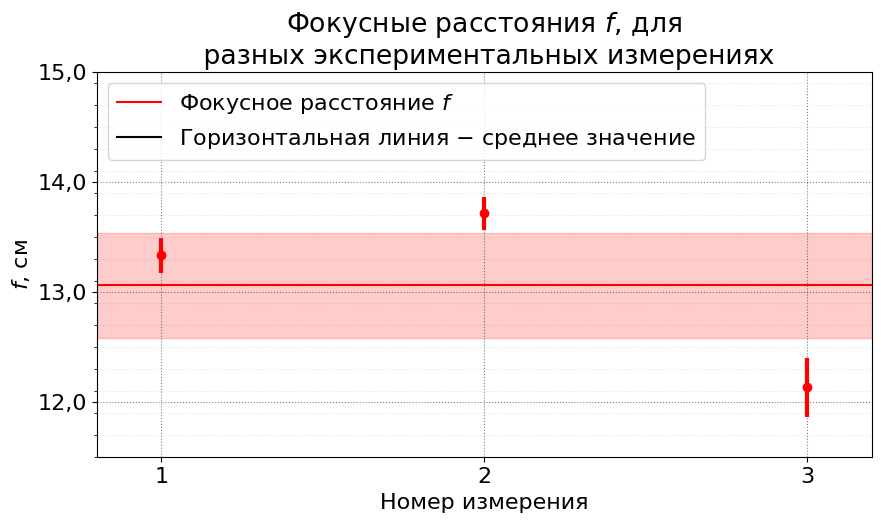

In [12]:
xMin = 0.8
xMax = 3.201 # max(bessel["n"])

yMin = 11.5
yMax = 15.0001

plotTitle       = 'Фокусные расстояния $f$, для\n разных экспериментальных измерениях'

xLabel          = r'Номер измерения'
yLabel          = r'$f$, см'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0.2
yMajorStep      = 1

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 1

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,5), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

x = np.array([xMin, xMax])

n = np.array(list(range(1, 4)))# + [8])
plt.errorbar(n, -otr["f"], yerr = otr["sig_f"], fmt = 'o', linewidth = 3, color = 'red')

plt.plot(x, np.array([-otr["avg_f"]]  * 2), color = 'red', label = "Фокусное расстояние $f$")

rect_f1 = mpl.patches.Rectangle((xMin, -otr["avg_f"] - -otr["sig_avg_f"]),
                               xMax - xMin, 2 * -otr["sig_avg_f"],
                               color = 'red',
                               alpha = 0.2)
axes.add_patch(rect_f1)

plt.plot(0, 0, color = 'black', label = "Горизонтальная линия $-$ среднее значение")

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(0, 20, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(1, 3.001, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.5)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/otr_f.png")
plt.show()

### Определение фокусного расстояния с помощью зрительной трубы

In [36]:
pipe = {
    "f1" : 29.8,
    "L"  : 43.2,
    "l1" : 14.8,
    "l2" : 15.1,
    "sig_r" : 0.05,
}

pipe["F1"] = pipe["f1"] - pipe["l1"]
pipe["F2"] = pipe["f1"] - pipe["l2"]
pipe["sig_F"] = (2) **0.5 * pipe["sig_r"]

print(pipe["F1"], "\t+-", pipe["sig_F"])
print(pipe["F2"], "\t+-", pipe["sig_F"], "\n")

pipe["eps_F1"] = pipe["sig_F"] / pipe["F1"]
pipe["eps_F2"] = pipe["sig_F"] / pipe["F2"]

pipe["dptr1"] = 1 / 0.093
pipe["eps_dptr1"] = 0.1 / 9.3
pipe["sig_dptr1"] = pipe["dptr1"] * pipe["eps_dptr1"]

pipe["dptr2"] = 1 / 0.115
pipe["eps_dptr2"] = 0.1 / 11.5
pipe["sig_dptr2"] = pipe["dptr2"] * pipe["eps_dptr2"]

pipe["dptr3"] = 1 / 0.149
pipe["eps_dptr3"] = 0.1 / 14.9
pipe["sig_dptr3"] = pipe["dptr3"] * pipe["eps_dptr3"]

print(pipe["dptr1"], "\t+-", pipe["sig_dptr1"])
print(pipe["dptr2"], "\t+-", pipe["sig_dptr2"])
print(pipe["dptr3"], "\t+-", pipe["sig_dptr3"])

15.0 	+- 0.07071067811865477
14.700000000000001 	+- 0.07071067811865477 

10.75268817204301 	+- 0.11562030292519365
8.695652173913043 	+- 0.07561436672967864
6.7114093959731544 	+- 0.04504301608035674
